In [68]:
# predict the next rssi value from current time value
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import glob
%matplotlib inline

In [2]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    outputs = np.empty(0)
    for _ in range(size_of_mini_batch):
        d = train_data[random.choice(train_data.keys())]
        index   = random.randint(0, len(d) - length_of_sequences)
        part    = d[index:index + length_of_sequences]
        inputs  = np.append(inputs, part[:, 0])
        outputs = np.append(outputs, part[-1, 2])
    inputs  = inputs.reshape(-1, length_of_sequences, 1)
    outputs = outputs.reshape(-1, 1)
    return (inputs, outputs)

In [31]:
def make_a_specified_file_batch(train_data, length_of_sequences, key):
    inputs  = np.empty(0)
    outputs = np.empty(0)

    d = train_data[key]
    for index in range(len(d) - length_of_sequences):
        part    = d[index:index + length_of_sequences]
        inputs  = np.append(inputs, part[:, 0])
        outputs = np.append(outputs, part[-1, 2])
    
    inputs  = inputs.reshape(-1, length_of_sequences, 1)
    outputs = outputs.reshape(-1, 1)
    return (inputs, outputs)

In [3]:
def make_prediction_initial(train_data, index, length_of_sequences):
    return train_data[index:index + length_of_sequences, 0]

In [60]:
#''' pred area judgement from rssi
train_data_path             = "./input/*0[1-5]_gaze_kawachi.csv"
num_of_input_nodes          = 1
num_of_hidden_nodes         = 20
num_of_output_nodes         = 1
length_of_sequences         = 40
num_of_training_epochs      = 5000

length_of_initial_sequences = 40
num_of_prediction_epochs    = 0

size_of_mini_batch          = 10
size_of_test_batch          = 100
learning_rate               = 0.01
forget_bias                 = 1.0

In [5]:
train_data = {path: np.loadtxt(path, delimiter=",", usecols=(1,), dtype=np.float32) for path in glob.glob(train_data_path)}
for (k, v) in train_data.items():
    n = len(v)
    rssi = v
    rssi = (rssi + 60.0)/30.0
    distance = np.linspace(30, 0, n, endpoint=True)
    valid = [1.0 if d <= 5 else 0.0 for d in distance]
    data = np.append(rssi, [distance, valid]).reshape((3, n)).T
    train_data[k] = data

In [7]:
# random seed fix
random.seed(0)
np.random.seed(0)
tf.set_random_seed(0)

In [62]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, length_of_sequences, num_of_input_nodes], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_output_nodes], name="supervisor")
    batch_size_ph = tf.placeholder(tf.int32, name="batch_size")

    with tf.name_scope("inference") as scope:
        weight1_var = tf.Variable(tf.truncated_normal([num_of_input_nodes, num_of_hidden_nodes], stddev=0.1), name="weight1")
        weight2_var = tf.Variable(tf.truncated_normal([num_of_hidden_nodes, num_of_output_nodes], stddev=0.1), name="weight2")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_output_nodes], stddev=0.1), name="bias2")

        weight1_hist = tf.histogram_summary("layer1/weights", weight1_var)
        weight2_hist = tf.histogram_summary("layer2/weights", weight2_var)
        bias1_hist = tf.histogram_summary("layer1/biases", bias1_var)
        bias2_hist = tf.histogram_summary("layer2/biases", bias2_var)

        in1 = tf.transpose(input_ph, [1, 0, 2])         # (batch, sequence, data) -> (sequence, batch, data)
        in2 = tf.reshape(in1, [-1, num_of_input_nodes]) # (sequence, batch, data) -> (sequence * batch, data)
        in3 = tf.matmul(in2, weight1_var) + bias1_var
        in4 = tf.split(0, length_of_sequences, in3)     # sequence * (batch, data)

        _cell = tf.nn.rnn_cell.BasicLSTMCell(num_of_hidden_nodes, forget_bias=forget_bias, state_is_tuple=True)
        cell = tf.nn.rnn_cell.MultiRNNCell([_cell]*3, state_is_tuple=True)
        zero_state = cell.zero_state(batch_size_ph, tf.float32)
        rnn_output, states_op = tf.nn.rnn(cell, in4, initial_state=zero_state)
        out1 = tf.matmul(rnn_output[-1], weight2_var) + bias2_var
        output_op = tf.nn.sigmoid(out1)

    with tf.name_scope("loss") as scope:
        log_likelihood = tf.reduce_mean(tf.reduce_sum(supervisor_ph * tf.log(output_op) + (1 - supervisor_ph) * tf.log(1 - output_op), reduction_indices=[1]))
        loss_op = -log_likelihood
        tf.scalar_summary("loss", loss_op)

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    with tf.name_scope("test") as scope:
        judge = tf.select(tf.greater(output_op, 0.5), tf.zeros_like(output_op, dtype=tf.float32), tf.ones_like(output_op, dtype=tf.float32))
        valid = tf.select(tf.equal(judge, supervisor_ph), tf.zeros_like(judge, dtype=tf.float32), tf.ones_like(judge, dtype=tf.float32))
        accuracy_op = tf.reduce_mean(valid)

    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        summary_writer = tf.train.SummaryWriter("data", graph=sess.graph)
        sess.run(init)

        for epoch in range(num_of_training_epochs):
            inputs, supervisors = make_mini_batch(train_data, size_of_mini_batch, length_of_sequences)

            train_dict = {
                input_ph:      inputs,
                supervisor_ph: supervisors,
                batch_size_ph: size_of_mini_batch,
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 10 == 0:
                summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
                summary_writer.add_summary(summary_str, epoch)
                
                # eval accuracy
                inputs, supervisors = make_mini_batch(train_data, size_of_test_batch, length_of_sequences)
                pred_dict = {
                    input_ph:      inputs,
                    supervisor_ph: supervisors,
                    batch_size_ph: size_of_test_batch,
                }
                pred = (sess.run(output_op, feed_dict=pred_dict))
                pred_bool = [v > 0.5 for v in pred]
                accuracy = sess.run(accuracy_op, feed_dict=pred_dict)

                print("train#%d, train loss: %e, accuracy: %4f" % (epoch + 1, train_loss, accuracy))

        for k, d in train_data.items():
            print(k)
            inputs, supervisors = make_a_specified_file_batch(train_data, length_of_sequences, k)
            pred_dict = {
                input_ph:      inputs,
                supervisor_ph: supervisors,
                batch_size_ph: len(inputs),
            }
            pred = (sess.run(output_op, feed_dict=pred_dict))
            pred_bool = [v[0] > 0.5 for v in pred]
            judge = np.empty(0, dtype=np.float32)
            for i in range(len(pred_bool)):
                judge = np.append(judge, pred_bool[i] == supervisors[i])
            print(judge)
                
#        saver.save(sess, "data/model")

train#10, train loss: 3.401311e-01, accuracy: 0.810000
train#20, train loss: 5.956727e-01, accuracy: 0.720000
train#30, train loss: 4.066068e-01, accuracy: 0.920000
train#40, train loss: 6.524973e-01, accuracy: 0.800000
train#50, train loss: 7.768610e-01, accuracy: 0.730000
train#60, train loss: 5.005215e-01, accuracy: 0.790000
train#70, train loss: 6.151218e-01, accuracy: 0.750000
train#80, train loss: 4.221573e-01, accuracy: 0.700000
train#90, train loss: 5.024215e-01, accuracy: 0.770000
train#100, train loss: 5.646107e-01, accuracy: 0.720000
train#110, train loss: 5.168368e-01, accuracy: 0.740000
train#120, train loss: 3.640248e-01, accuracy: 0.930000
train#130, train loss: 2.343924e-01, accuracy: 0.940000
train#140, train loss: 2.426682e-01, accuracy: 0.810000
train#150, train loss: 4.107684e-01, accuracy: 0.850000
train#160, train loss: 1.470406e-01, accuracy: 0.960000
train#170, train loss: 7.818003e-02, accuracy: 0.940000
train#180, train loss: 1.448371e-01, accuracy: 0.800000
t

,accuracy,epoch
0,0.81,10
1,0.72,20
2,0.92,30
3,0.80,40
4,0.73,50


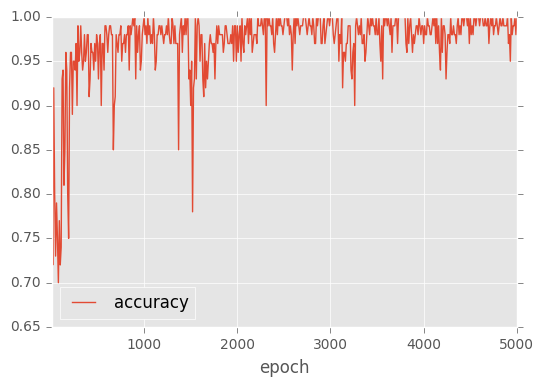

In [73]:
## result graph
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
matplotlib.rc('font', **font)

accuracy = [0.810000, 0.720000, 0.920000, 0.800000, 0.730000, 0.790000, 0.750000, 0.700000, 0.770000, 0.720000, 0.740000, 0.930000, 0.940000, 0.810000, 0.850000, 0.960000, 0.940000, 0.800000, 0.750000, 0.920000, 0.960000, 0.960000, 0.890000, 0.950000, 0.950000, 0.940000, 0.970000, 0.900000, 0.990000, 0.950000, 0.960000, 0.990000, 0.960000, 0.940000, 0.950000, 0.980000, 0.950000, 0.960000, 0.980000, 0.980000, 0.910000, 0.930000, 0.970000, 0.960000, 0.960000, 0.940000, 0.970000, 0.950000, 0.980000, 0.970000, 0.930000, 0.970000, 0.980000, 0.900000, 0.970000, 0.970000, 0.940000, 0.990000, 0.990000, 0.980000, 0.960000, 0.980000, 0.990000, 0.990000, 0.980000, 0.980000, 0.850000, 0.900000, 0.910000, 0.980000, 0.970000, 0.960000, 0.980000, 0.980000, 0.990000, 0.950000, 0.970000, 0.970000, 0.980000, 0.960000, 0.980000, 0.980000, 0.990000, 0.940000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 1.000000, 0.930000, 0.990000, 0.960000, 0.980000, 0.990000, 0.940000, 0.950000, 0.980000, 0.990000, 1.000000, 0.980000, 0.990000, 0.970000, 1.000000, 0.980000, 0.990000, 0.970000, 0.980000, 0.970000, 1.000000, 0.980000, 0.940000, 0.950000, 0.980000, 0.980000, 0.990000, 0.990000, 0.980000, 0.990000, 0.980000, 0.970000, 0.980000, 0.980000, 0.990000, 0.980000, 1.000000, 0.980000, 0.970000, 0.970000, 1.000000, 0.990000, 0.970000, 0.990000, 0.970000, 0.970000, 0.970000, 0.850000, 0.980000, 0.990000, 1.000000, 0.960000, 0.990000, 0.980000, 1.000000, 0.980000, 1.000000, 1.000000, 0.930000, 0.940000, 0.900000, 0.950000, 0.780000, 0.920000, 0.930000, 1.000000, 0.930000, 0.990000, 1.000000, 0.990000, 0.950000, 0.980000, 0.980000, 0.930000, 0.910000, 0.970000, 0.920000, 0.950000, 0.930000, 0.950000, 0.970000, 0.980000, 0.970000, 0.970000, 0.960000, 0.970000, 0.930000, 0.970000, 0.990000, 0.970000, 0.990000, 0.980000, 0.980000, 0.980000, 0.980000, 0.960000, 0.970000, 0.990000, 0.990000, 0.980000, 0.970000, 0.970000, 0.970000, 0.980000, 0.970000, 0.990000, 0.950000, 0.990000, 0.990000, 0.950000, 0.990000, 0.960000, 0.980000, 0.990000, 0.950000, 1.000000, 0.970000, 0.960000, 0.990000, 0.980000, 0.990000, 1.000000, 0.970000, 1.000000, 0.980000, 1.000000, 0.960000, 0.970000, 0.980000, 0.980000, 0.980000, 0.970000, 1.000000, 0.990000, 0.990000, 0.990000, 1.000000, 0.990000, 0.980000, 1.000000, 1.000000, 0.900000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.970000, 0.960000, 0.980000, 1.000000, 0.980000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 0.980000, 0.990000, 0.980000, 0.940000, 0.980000, 1.000000, 0.970000, 1.000000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 0.990000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.990000, 0.970000, 0.970000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.970000, 0.970000, 0.990000, 1.000000, 0.970000, 0.980000, 0.990000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.980000, 0.970000, 0.980000, 0.990000, 1.000000, 1.000000, 0.950000, 0.980000, 0.970000, 1.000000, 0.920000, 0.960000, 0.960000, 0.950000, 0.970000, 0.970000, 0.990000, 0.990000, 0.990000, 0.940000, 0.930000, 0.960000, 0.970000, 0.900000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 0.980000, 1.000000, 0.970000, 0.970000, 0.980000, 0.950000, 0.960000, 0.980000, 1.000000, 0.990000, 0.980000, 1.000000, 0.990000, 1.000000, 0.990000, 0.990000, 0.980000, 1.000000, 0.980000, 0.980000, 1.000000, 0.970000, 0.950000, 0.990000, 0.930000, 1.000000, 0.990000, 1.000000, 1.000000, 0.990000, 1.000000, 0.990000, 0.980000, 1.000000, 0.960000, 0.990000, 0.990000, 0.990000, 1.000000, 1.000000, 0.970000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 1.000000, 0.970000, 0.960000, 1.000000, 0.970000, 0.990000, 1.000000, 0.980000, 0.960000, 0.980000, 0.970000, 0.980000, 0.990000, 0.990000, 0.980000, 1.000000, 0.990000, 0.980000, 0.990000, 0.990000, 0.970000, 0.990000, 0.980000, 0.980000, 1.000000, 0.990000, 0.990000, 0.980000, 0.980000, 0.990000, 1.000000, 0.990000, 1.000000, 0.970000, 1.000000, 0.970000, 0.990000, 0.960000, 0.940000, 1.000000, 0.960000, 0.990000, 0.990000, 0.980000, 0.930000, 0.960000, 0.980000, 0.980000, 0.970000, 1.000000, 0.980000, 0.980000, 0.990000, 0.980000, 0.980000, 0.970000, 0.990000, 1.000000, 0.980000, 0.990000, 0.980000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 0.970000, 1.000000, 0.980000, 0.990000, 0.980000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 1.000000, 1.000000, 1.000000, 0.990000, 0.990000, 1.000000, 0.990000, 0.990000, 1.000000, 0.970000, 0.990000, 1.000000, 0.990000, 1.000000, 0.980000, 0.990000, 0.990000, 1.000000, 0.990000, 0.980000, 0.990000, 1.000000, 0.990000, 0.990000, 1.000000, 0.990000, 0.990000, 0.990000, 0.990000, 1.000000, 0.970000, 0.980000, 0.950000, 1.000000, 0.980000, 0.990000, 0.990000, 1.000000, 0.980000, 1.000000]
df = pd.DataFrame({
        'accuracy': accuracy,
        'epoch': range(10, 5010, 10)})
df.plot(x='epoch', y='accuracy')
df.head()